In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import math
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from numpy import mean
from numpy import std
from tensorflow.keras.optimizers import SGD

In [3]:
df = pd.read_csv (r'C:\Users\conal\Desktop\MCM\Practicum\data\min,max,average gas 11-26 to 01-26 QUERY 2.csv', header=0)

In [35]:
ts = df[['block_timestamp', 'min_gas_price']]

In [36]:
ts['block_timestamp'] = pd.to_datetime(ts['block_timestamp'])

C:\Users\conal\AppData\Local\Temp/ipykernel_17640/3010723335.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['block_timestamp'] = pd.to_datetime(ts['block_timestamp'])


In [37]:
ts =ts.set_index('block_timestamp').resample('5 Min').mean()

In [38]:
ts_mean, ts_std = mean(ts["min_gas_price"]), std(ts["min_gas_price"])

In [39]:
# identify outliers
cut_off = ts_std * 2
lower, upper = ts_mean - cut_off, ts_mean + cut_off
for index,row in ts.iterrows():
  if row["min_gas_price"] < lower:
    row["min_gas_price"]=lower
  elif row["min_gas_price"] > upper:
    row["min_gas_price"]=upper

In [40]:
outliers_removed = [x for x in ts["min_gas_price"] if x >= lower and x <= upper]

In [43]:
ts2 = ts[["min_gas_price"]]
ts2 = ts2.dropna()

In [49]:
training_set = ts2['2021-11-26 00:00:00':'2021-12-7 23:59:59']
test_set = ts2['2021-12-8 00:00:00':'2021-12-11 23:59:59']

In [50]:
sc = MinMaxScaler(feature_range=(0,1))
training_set = sc.fit_transform(training_set)
test_set = sc.transform(test_set)

Epoch 1/500


D:\Anaconda\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


28/28 [==============================] - 3s 32ms/step - loss: 0.1092 - val_loss: 0.0915
Epoch 2/500
28/28 [==============================] - 0s 11ms/step - loss: 0.0954 - val_loss: 0.0881
Epoch 3/500
28/28 [==============================] - 0s 9ms/step - loss: 0.0907 - val_loss: 0.0866
Epoch 4/500
28/28 [==============================] - 0s 9ms/step - loss: 0.0870 - val_loss: 0.0850
Epoch 5/500
28/28 [==============================] - 0s 9ms/step - loss: 0.0839 - val_loss: 0.0838
Epoch 6/500
28/28 [==============================] - 0s 9ms/step - loss: 0.0823 - val_loss: 0.0837
Epoch 7/500
28/28 [==============================] - 0s 9ms/step - loss: 0.0810 - val_loss: 0.0829
Epoch 8/500
28/28 [==============================] - 0s 9ms/step - loss: 0.0799 - val_loss: 0.0830
Epoch 9/500
28/28 [==============================] - 0s 9ms/step - loss: 0.0793 - val_loss: 0.0831
Epoch 10/500
28/28 [==============================] - 0s 9ms/step - loss: 0.0789 - val_loss: 0.0830
Epoch 11/500
28/28 

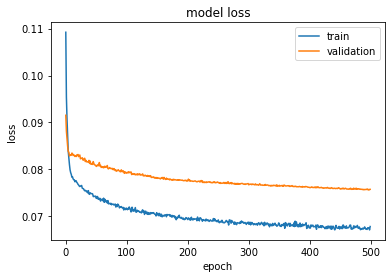

In [62]:
#Create x, y test and train data windows and into input and outputs
training_set = np.array(training_set)
test_set = np.array(test_set)
x_train = []
y_train = []
previous =15
for i in range(len(training_set)-previous-1):
    x_train.append(training_set[i:i+previous])
    y_train.append(training_set[i+previous])
x_train, y_train = np.array(x_train), np.array(y_train)
# reshape input to be 3D [samples, timesteps]
y_train = np.reshape(y_train, (y_train.shape[0],-1))
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape, y_train.shape
x_test = []
y_test = []
for i in range(len(test_set)-previous-1):
    x_test.append(test_set[i:i+previous])
    y_test.append(test_set[i+previous])
x_test, y_test = np.array(x_test), np.array(y_test)
# reshape input to be 2D [samples, timesteps]
y_test = np.reshape(y_test, (y_test.shape[0],-1))
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
#Create LSTM Model
modelL = Sequential()
modelL.add(LSTM(units =15,activation='tanh',input_shape=(x_train.shape[1], x_train.shape[2]),dropout=0.01))
modelL.add(Dense(2))
opt = SGD(lr=0.01, decay=0.0001)
modelL.compile(loss='mean_absolute_error', optimizer=opt)
# fit network
history2 = modelL.fit(x_train, y_train, epochs=500,batch_size=112,validation_split=0.10,shuffle=False,verbose=1)
# summarize history for loss
train_mseL = modelL.evaluate(x_train,y_train)
test_mseL = modelL.evaluate(x_test, y_test)
print('Train: %.3f, Test: %.3f' % (train_mseL, test_mseL))
#visualize results 
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

LSTM : 0.067
LSTM : 0.010
LSTM : 0.735
LSTM : 0.099
(3440, 1)


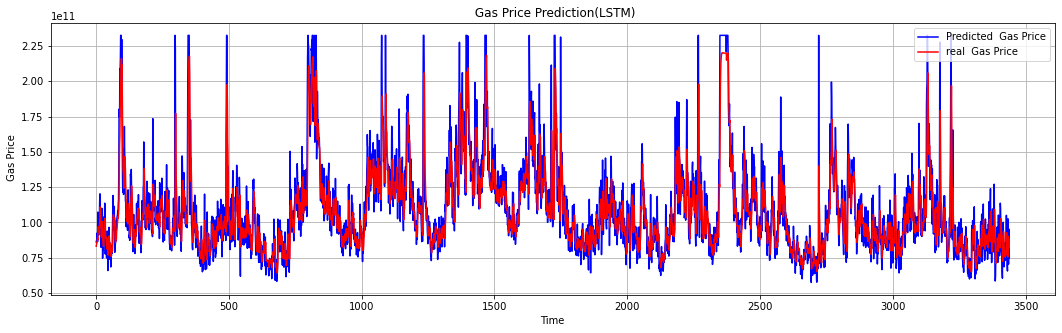

In [63]:
# make a prediction for training data
trainLSTM = modelL.predict(x_train)
#calculate error rates 
maeLSTMTR=mean_absolute_error(y_train, trainLSTM)
mseLSTMTR=mean_squared_error(y_train, trainLSTM)
r2LSTMTR=r2_score(y_train, trainLSTM)
rmseLSTMTR=sqrt(mean_squared_error(y_train, trainLSTM))
print('LSTM : %.3f'%maeLSTMTR)
print('LSTM : %.3f'%mseLSTMTR)
print('LSTM : %.3f'%r2LSTMTR)
print('LSTM : %.3f'%rmseLSTMTR)
print(trainLSTM.shape)
# invert scaling for forecast and real 
trainLSTM = sc.inverse_transform(trainLSTM)
y_train = sc.inverse_transform(y_train)
plt.figure(figsize=(18,5))
#visualaize forecastings 
plt.plot(y_train, color='blue',label='Predicted '+' Gas Price')
plt.plot(trainLSTM, color='red',label='real '+' Gas Price')
plt.title(' Gas Price Prediction(LSTM)')
plt.xlabel('Time')
plt.grid()
plt.ylabel(' Gas Price')
plt.legend()
plt.show()